In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = "/content/drive/MyDrive/Chest Rays/data"

In [ ]:
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from glob import glob
from PIL import Image
import os
import random
import cv2
import torch
import torchvision

Clasa cu Datasetul


In [ ]:
source_dirs= ["Normal", "Viral Pnemuonia", "COVID", "Lung_Opacity"]
root_dir  = "/content/drive/MyDrive/Chest Rays/data"

class ChestXRayDataset(torch.utils.data.Dataset):
    def __init__(self, image_dirs, transform):
        def get_images(class_name):
            images = [x for x in os.listdir(image_dirs[class_name]) if x[-3:].lower().endswith('png')]
            print(f'Found {len(images)} {class_name} examples')
            return images
        
        self.images = {}
        self.class_names = ['normal', 'viral', 'covid', 'lung_opacity']
        
        for class_name in self.class_names:
            self.images[class_name] = get_images(class_name)
            
        self.image_dirs = image_dirs
        self.transform = transform
        
    
    def __len__(self):
        return sum([len(self.images[class_name]) for class_name in self.class_names])
    
    
    def __getitem__(self, index):
        class_name = random.choice(self.class_names)
        index = index % len(self.images[class_name])
        image_name = self.images[class_name][index]
        image_path = os.path.join(self.image_dirs[class_name], image_name)
        image = Image.open(image_path).convert('RGB')
        return self.transform(image), self.class_names.index(class_name)

(mean = [0.485,0.456,0.406], std = [0.229, 0.224, 0.225]) sunt valorile standard de normalizare ale imaginiilor din pytorch / imagenet


In [ ]:
train_transform = torchvision.transforms.Compose([
                                                  torchvision.transforms.RandomHorizontalFlip(),
                                                  torchvision.transforms.ToTensor(),
                                                  torchvision.transforms.Normalize(mean = [0.485,0.456,0.406], std = [0.229, 0.224, 0.225]),
                                                  torchvision.transforms.Resize((128,128))
])


test_transform = torchvision.transforms.Compose([ 
                                                  torchvision.transforms.ToTensor(),
                                                  torchvision.transforms.Normalize([0.485,0.456,0.406], [0.229, 0.224, 0.225]),
                                                  torchvision.transforms.Resize((128,128))
])
val_transform = torchvision.transforms.Compose([ 
                                                  torchvision.transforms.ToTensor(),
                                                  torchvision.transforms.Normalize([0.485,0.456,0.406], [0.229, 0.224, 0.225]),
                                                  torchvision.transforms.Resize((128,128))
])



Split


In [ ]:
train_dirs = {
    "normal" : "/content/drive/MyDrive/Chest Rays/data/Normal",
    "viral" : "/content/drive/MyDrive/Chest Rays/data/Viral Pneumonia",
    "covid" : "/content/drive/MyDrive/Chest Rays/data/COVID",
    "lung_opacity" : "/content/drive/MyDrive/Chest Rays/data/Lung_Opacity"
}
dataset = ChestXRayDataset(train_dirs, train_transform)

training_data_size = 0.7
test_data_size = 0.15
val_data_size = 0.15

train_size = int(training_data_size * len(dataset))
test_size = int((len(dataset) - train_size)/2)
val_size = test_size

train_dataset, valid_dataset, test_dataset  = torch.utils.data.random_split(dataset, (train_size, val_size, test_size)
)

print("Length of train set   :  ", len(train_dataset))
print("Length of test set    :  ", len(test_dataset))
print("Length of val set     :  ", len(valid_dataset))


Found 10192 normal examples
Found 1345 viral examples
Found 3616 covid examples
Found 6012 lung_opacity examples
Length of train set   :   14815
Length of test set    :   3175
Length of val set     :   3175


Data loaders

In [ ]:
batch_size = 32

data_train_loader = torch.utils.data.DataLoader(train_dataset, batch_size= batch_size, shuffle = True)
data_test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
data_val_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)

print("Length of training batches", len(data_train_loader))
print("Lentgth of test batches", len(data_test_loader))
print("Lentgth of val batches", len(data_val_loader))


Length of training batches 463
Lentgth of test batches 100
Lentgth of val batches 100


In [ ]:
data_iter = iter(data_val_loader)
images, labels = data_iter.next()
print(type(images))
print(images.shape)
print(labels.shape)

<class 'torch.Tensor'>
torch.Size([32, 3, 128, 128])
torch.Size([32])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(3)


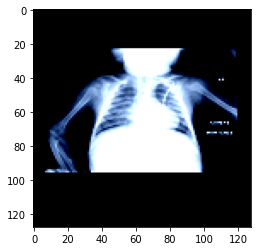

In [ ]:
img = images[9].numpy().transpose(1, 2, 0)
print(labels[9])
plt.imshow(img,cmap="gray")

In [ ]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from IPython.core.debugger import set_trace
import numpy as np
from matplotlib import pyplot

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(8, 8)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16, 100)
        self.fc2 = nn.Linear(100, 50)
        self.fc3 = nn.Linear(50, 4)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
       # print(x.shape)
        x = self.pool(F.relu(self.conv2(x)))
        #print(x.shape)
        x = x.view(-1, 16)
        #print(x.shape)
        x = F.relu(self.fc1(x))
        #print(x.shape)
        self.conv_act = self.fc2(x).view(x.shape[0],-1)
        #print(self.conv_act.shape)
        self.lin = self.fc3(self.conv_act)
        #print(self.lin.shape)
        x = F.log_softmax(self.lin, dim=1)
        #print(x.shape)
        return x

In [ ]:
# define two functions, one for training the model and one for testing it
class_names = ["normal ", "viral ","covid ", "lung_opacity"]

def train(model, device, train_loader, optimizer, epoch):
    model.train()
    all_losses = []
    for batch_idx, (data, target) in enumerate(train_loader):
        # put the data on the GPU
        data, target = data.to(device), target.to(device)
        # initialize as zeros all the gradients of the model
        optimizer.zero_grad()
        
        # obtain the predictions in the FORWARD pass of the network
        output = model(data)
        # compute average LOSS for the current batch
        loss = F.nll_loss(output, target)
        all_losses.append(loss.detach().cpu().numpy())
        # BACKPROPAGATE the gradients
        loss.backward()
        # use the computed gradients to OPTIMISE the model
        optimizer.step()
        # print the training loss of each batch
        if batch_idx %12== 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    return np.array(all_losses).mean()

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        num_iter = 0
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            # obtain the prediction by a forward pass
            output = model(data)
            # calculate the loss for the current batch and add it across the entire dataset
            test_loss += F.nll_loss(output, target) # sum up batch loss
            # compute the accuracy of the predictions across the entire dataset
            # get the most probable prediction
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).float().mean().item()
            num_iter += 1
    test_loss /= num_iter
    test_accuracy = 100. * correct / num_iter
    # print the Accuracy for the entire dataset
    print('\nTest set: Average loss: {:.4f}, Accuracy: ({:.0f}%)\n'.format(
        test_loss,
        test_accuracy))
    return test_loss, test_accuracy

<bound method Module.parameters of Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=8, stride=8, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=16, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=50, bias=True)
  (fc3): Linear(in_features=50, out_features=4, bias=True)
)>
Train Epoch: 1 [0/14815 (0%)]	Loss: 1.382390
Train Epoch: 1 [384/14815 (3%)]	Loss: 1.380145
Train Epoch: 1 [768/14815 (5%)]	Loss: 1.374237
Train Epoch: 1 [1152/14815 (8%)]	Loss: 1.389718
Train Epoch: 1 [1536/14815 (10%)]	Loss: 1.346436
Train Epoch: 1 [1920/14815 (13%)]	Loss: 1.215548
Train Epoch: 1 [2304/14815 (16%)]	Loss: 1.082886
Train Epoch: 1 [2688/14815 (18%)]	Loss: 0.837436
Train Epoch: 1 [3072/14815 (21%)]	Loss: 0.945585
Train Epoch: 1 [3456/14815 (23%)]	Loss: 0.829403
Train Epoch: 1 [3840/14815 (26%)]	Loss: 1.050529
Train Epoch: 1 [4224/14815 (29%)]	Loss: 0.

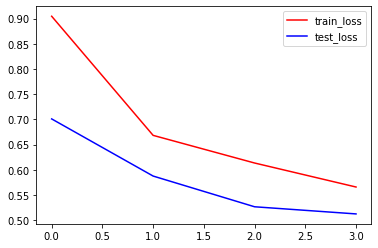

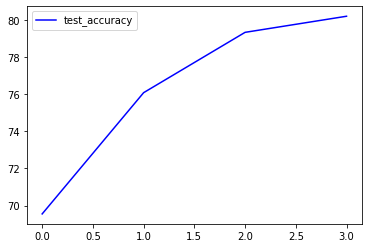

In [ ]:
use_cuda = torch.cuda.is_available()
torch.manual_seed(1)
device = torch.device("cuda" if use_cuda else "cpu")

def plot_loss(loss, label, color='blue'):
    pyplot.plot(loss, label=label, color=color)
    pyplot.legend()

# move the model to the GPU (when available)
model = Net().to(device)
print(model.parameters)
# create an Stochastic Gradient Descent optimiser
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

losses_train = []
losses_test = []
accuracy_test = []
for epoch in range(1, 5):
    train_loss = train(model, device, data_train_loader, optimizer, epoch)
    test_loss, test_accuracy = test(model, device, data_test_loader)
    losses_train.append(train_loss)
    losses_test.append(test_loss)
    accuracy_test.append(test_accuracy)

#plot the loss/accuracy    
pyplot.figure(1)
plot_loss(losses_train,'train_loss','red')
plot_loss(losses_test,'test_loss')
pyplot.figure(2)
plot_loss(accuracy_test,'test_accuracy')

In [ ]:
PATH = 'covid19.pt'
torch.save(model.state_dict(), PATH)

# Loading the trained network
model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

Compute accuracy and confusion matrix

In [ ]:
from sklearn.metrics import confusion_matrix
import numpy
predictions=numpy.array([])
targets=numpy.array([])
for data, target in data_test_loader:
  data, target = data.to(device), target.to(device)
  y_pred = model(data)
  y_pred = y_pred.argmax(dim=1)
  y_pred = y_pred.cpu().data.numpy()
  y_test=target.cpu().data.numpy()

  predictions=numpy.append(predictions,y_pred)
  targets=numpy.append(targets,y_test)


print('Accuracy of the model on test set : ',(((predictions.reshape(-1) == targets).sum())/float(predictions.shape[0])).item(),"%")

print("Confusion Matrix : ")
confusion_matrix(predictions,targets)

Accuracy of the model on test set :  0.7984251968503937 %
Confusion Matrix : 


array([[562,  10,  60,  78],
       [ 26, 792,   3,   3],
       [ 99,  21, 575, 109],
       [ 84,  17, 130, 606]])

In [ ]:
class_names = ["normal ", "viral ","covid ", "lung_opacity"]

def show_images(images,labels,preds):
    plt.figure(figsize=(15,7))
    for i , image in enumerate(images):
        plt.subplot(1,11,i+1, xticks = [], yticks= [])
        image = image.numpy().transpose((1,2,0))
        mean = np.array([0.5, 0.5, 0.4])
        std = np.array([0.2, 0.2, 2])
        image = image*std + mean
        image = np.clip(image,0.,1.)
        plt.imshow(image)
        
        colorr = "green"
        if(preds[i] != labels[i]):
            
            colorr="red"
            
        plt.xlabel(f'{class_names[int(labels[i].numpy())]}')
        plt.ylabel(f'{class_names[int(preds[i].numpy())]}', color=colorr)
    plt.tight_layout()
    plt.show()
    
def test_predicts():
    resnet18.eval()
    images, labels = next(iter(data_test_loader))
    outputs = resnet18(images)
    _, preds = torch.max(outputs, 1)
    show_images(images, labels, preds)

In [ ]:
resnet18 = torchvision.models.resnet18(pretrained=True)
print(resnet18)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
resnet18.fc = torch.nn.Linear(in_features=512, out_features=4)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet18.parameters(), lr=3e-5)

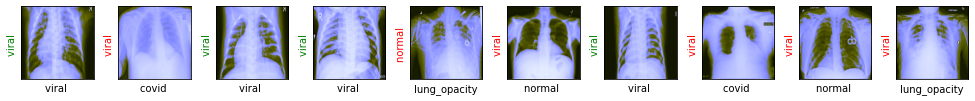

In [ ]:
test_predicts()

In [ ]:
def train(epochs):
    print('Starting training..')
    for e in range(0, epochs):
        print('='*20)
        print(f'Starting epoch {e + 1}/{epochs}')
        print('='*20)

        train_loss = 0.
        val_loss = 0.

        resnet18.train() # set model to training phase

        for train_step, (images, labels) in enumerate(data_test_loader):
            optimizer.zero_grad()
            
            outputs = resnet18(images)
            
            loss = loss_fn(outputs, labels)
            
            loss.backward()
            
            optimizer.step()
            train_loss += loss.item()
            
            if train_step % 20 == 0:
                print('Evaluating at step', train_step)

                accuracy = 0

                resnet18.eval() # set model to eval phase
                for val_step, (images, labels) in enumerate(data_test_loader):
                    outputs = resnet18(images)
                    loss = loss_fn(outputs, labels)
                    val_loss += loss.item()

                    _, preds = torch.max(outputs, 1)
                    accuracy += sum((preds == labels).numpy())

                val_loss /= (val_step + 1)
                accuracy = accuracy/len(test_dataset)
                print(f'Validation Loss: {val_loss:.4f}, Accuracy: {accuracy:.4f}')

                test_predicts()

                resnet18.train()

                if accuracy >= 0.98:
                    print('Performance condition satisfied, stopping..')
                    return

        train_loss /= (train_step + 1)

        print(f'Training Loss: {train_loss:.4f}')
    print('Training complete..')

Starting training..
Starting epoch 1/4
Evaluating at step 0
Validation Loss: 1.4191, Accuracy: 0.2598


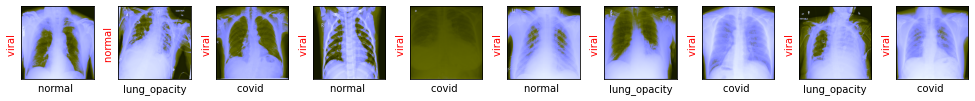

Evaluating at step 20
Validation Loss: 0.9689, Accuracy: 0.6419


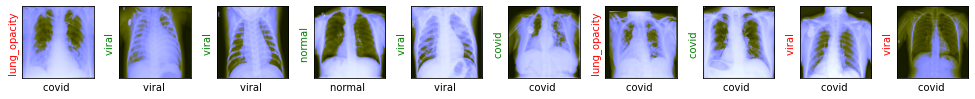

Evaluating at step 40
Validation Loss: 0.6427, Accuracy: 0.8013


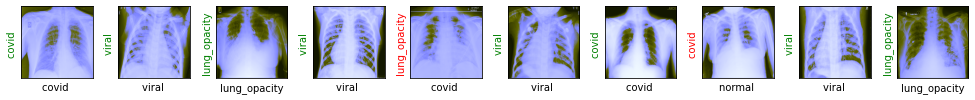

Evaluating at step 60
Validation Loss: 0.5025, Accuracy: 0.8365


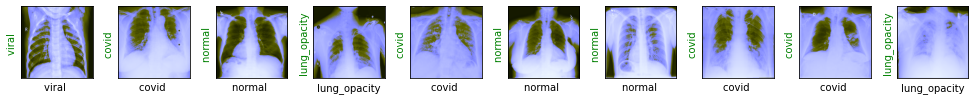

Evaluating at step 80
Validation Loss: 0.4223, Accuracy: 0.8542


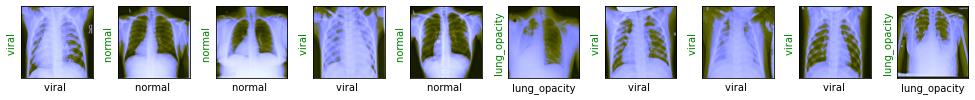

Evaluating at step 100
Validation Loss: 0.3656, Accuracy: 0.8784


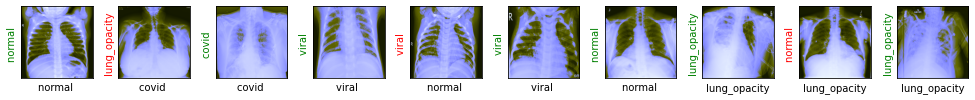

Evaluating at step 120
Validation Loss: 0.3399, Accuracy: 0.8888


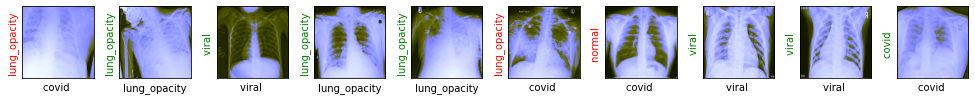

Evaluating at step 140
Validation Loss: 0.3259, Accuracy: 0.8904


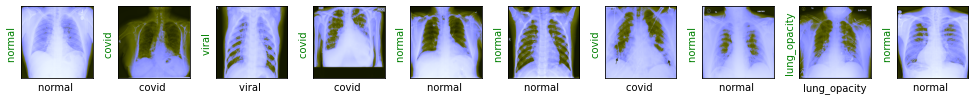

Evaluating at step 160
Validation Loss: 0.2908, Accuracy: 0.9017


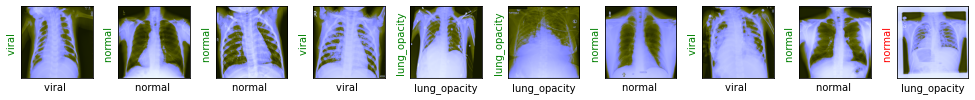

Evaluating at step 180
Validation Loss: 0.2828, Accuracy: 0.9014


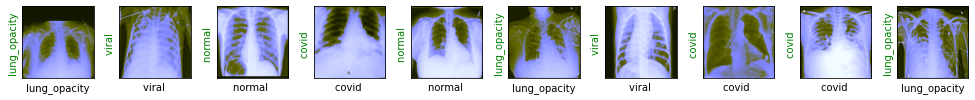

Evaluating at step 200
Validation Loss: 0.2636, Accuracy: 0.9156


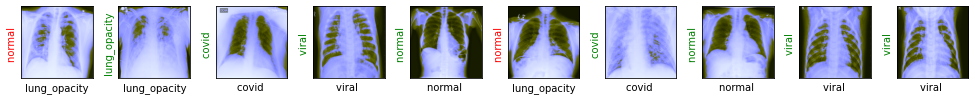

Evaluating at step 220
Validation Loss: 0.2418, Accuracy: 0.9162


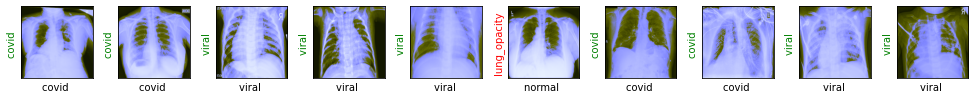

Evaluating at step 240
Validation Loss: 0.2402, Accuracy: 0.9181


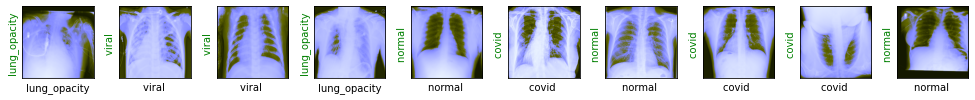

Evaluating at step 260
Validation Loss: 0.2703, Accuracy: 0.9068


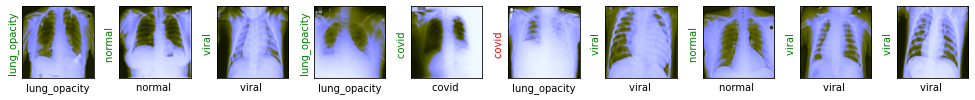

Evaluating at step 280
Validation Loss: 0.2248, Accuracy: 0.9247


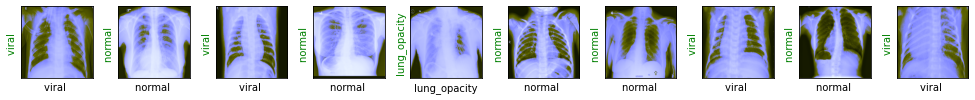

Evaluating at step 300
Validation Loss: 0.2135, Accuracy: 0.9222


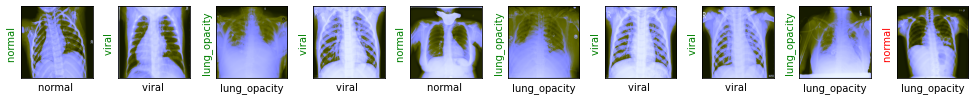

Training Loss: 0.4754
Starting epoch 2/4
Evaluating at step 0
Validation Loss: 0.2983, Accuracy: 0.8898


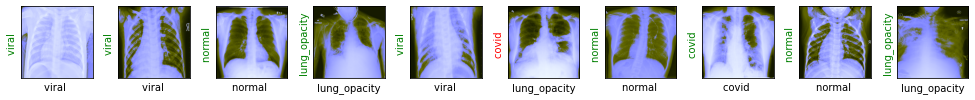

Evaluating at step 20
Validation Loss: 0.2346, Accuracy: 0.9197


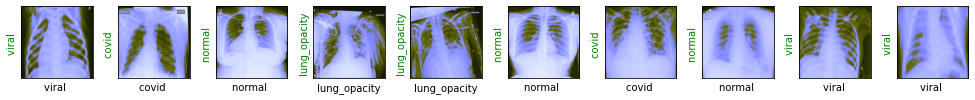

Evaluating at step 40
Validation Loss: 0.2156, Accuracy: 0.9194


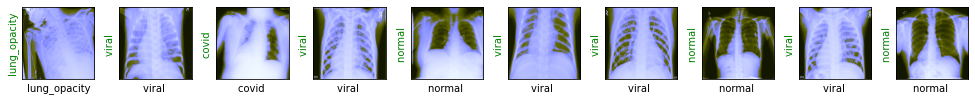

Evaluating at step 60
Validation Loss: 0.1856, Accuracy: 0.9383


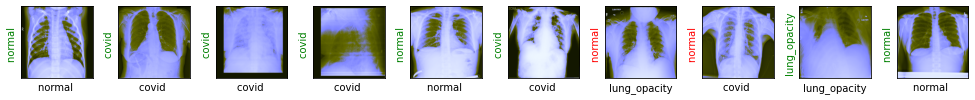

Evaluating at step 80
Validation Loss: 0.2024, Accuracy: 0.9361


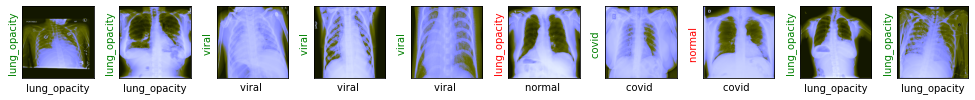

Evaluating at step 100
Validation Loss: 0.1840, Accuracy: 0.9389


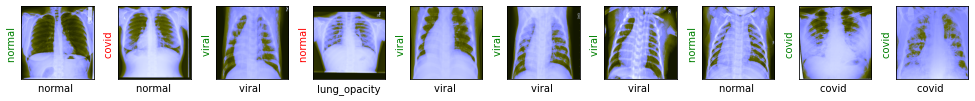

Evaluating at step 120
Validation Loss: 0.1553, Accuracy: 0.9531


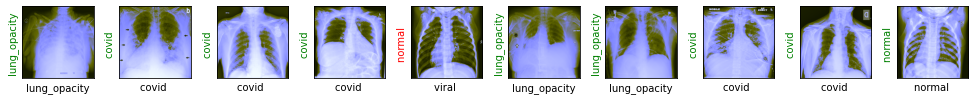

Evaluating at step 140
Validation Loss: 0.1659, Accuracy: 0.9436


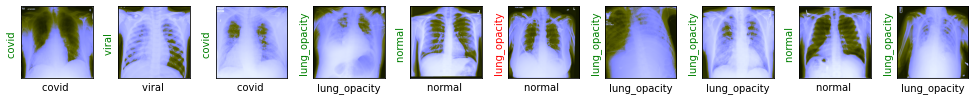

Evaluating at step 160


In [ ]:
%%time
train(epochs = 4)